In [1]:
# importing required modules
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import warnings
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# VGG 16 CNN Architecture
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(272, 363, 3)),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The fourth convolution
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The Fifth convolution
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 272, 363, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 272, 363, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 136, 181, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 136, 181, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 68, 90, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 90, 256)       295168    
____

# 

In [4]:
#from pathlib import Path

#root_dir = path_images
#root = Path(root_dir)

In [5]:
#rm -rf `find -type d -name .ipynb_checkpoints`

In [6]:
# augmenting the ibput imges
image_gen = ImageDataGenerator(width_shift_range=0.1, # Shift the pic width by a max of 10%
                               validation_split = 0.4, # Split the Data into 80,20 %
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
# initializing paths of input images         
path_images = 'Dataset/train'
image_gen.flow_from_directory(path_images)
#image_gen.flow_from_directory('/home/ec2-user/SageMaker/Training_Data/Corn_Valid_Data')

#print(image_gen)

batch_size = 32
image_shape = (272,363,3)

# train on images
train_image_gen = image_gen.flow_from_directory(path_images,
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                                shuffle = True,
                                                subset='training',
                                               class_mode='categorical')

valid_image_gen = image_gen.flow_from_directory(path_images,
                                                target_size=image_shape[:2],
                                               batch_size=batch_size,
                                                shuffle = True,
                                                subset='validation',
                                               class_mode='categorical')

Found 25414 images belonging to 25 classes.
Found 15259 images belonging to 25 classes.
Found 10155 images belonging to 25 classes.


In [7]:
valid_image_gen.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Grape___Black_rot': 4,
 'Grape___Esca_(Black_Measles)': 5,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 6,
 'Grape___healthy': 7,
 'Peach___Bacterial_spot': 8,
 'Peach___healthy': 9,
 'Potato___Early_blight': 10,
 'Potato___Late_blight': 11,
 'Potato___healthy': 12,
 'Strawberry___Leaf_scorch': 13,
 'Strawberry___healthy': 14,
 'Tomato___Bacterial_spot': 15,
 'Tomato___Early_blight': 16,
 'Tomato___Late_blight': 17,
 'Tomato___Leaf_Mold': 18,
 'Tomato___Septoria_leaf_spot': 19,
 'Tomato___Spider_mites Two-spotted_spider_mite': 20,
 'Tomato___Target_Spot': 21,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 22,
 'Tomato___Tomato_mosaic_virus': 23,
 'Tomato___healthy': 24}

In [8]:
pwd

'C:\\Users\\Murtaza\\Plant_Diseases'

In [8]:
warnings.filterwarnings('ignore')

#es = EarlyStopping(monitor='val_acc', mode='max', verbose=1 , patience = 10)
cb = []
checkpoint_dir = 'Checkpoints'
ckp_saver = ModelCheckpoint(checkpoint_dir + "/model.{epoch:02d}-{loss:.2f}.h5", monitor='loss', verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True, mode='auto', period=10)
cb.append(ckp_saver)


results = model.fit_generator(train_image_gen,epochs=20,
                              steps_per_epoch=train_image_gen.samples//batch_size,
                              validation_data=valid_image_gen,
                             validation_steps=valid_image_gen.samples//batch_size,
                             callbacks=cb)
model.save('Plant_Classifier60.h5')

Epoch 1/20
476/476 [==============================] - 381s 801ms/step - loss: 2.4172 - acc: 0.2820 - val_loss: 1.7230 - val_acc: 0.4505
Epoch 2/20
476/476 [==============================] - 370s 778ms/step - loss: 1.5269 - acc: 0.5034 - val_loss: 1.3212 - val_acc: 0.5694
Epoch 3/20
476/476 [==============================] - 369s 776ms/step - loss: 1.0151 - acc: 0.6619 - val_loss: 0.8354 - val_acc: 0.7270
Epoch 4/20
476/476 [==============================] - 369s 775ms/step - loss: 0.7433 - acc: 0.7575 - val_loss: 0.6323 - val_acc: 0.7936
Epoch 5/20
476/476 [==============================] - 368s 774ms/step - loss: 0.5795 - acc: 0.8065 - val_loss: 0.5681 - val_acc: 0.8090
Epoch 6/20
476/476 [==============================] - 368s 773ms/step - loss: 0.4775 - acc: 0.8375 - val_loss: 0.6454 - val_acc: 0.7861
Epoch 7/20
476/476 [==============================] - 367s 772ms/step - loss: 0.4086 - acc: 0.8625 - val_loss: 0.4020 - val_acc: 0.8690
Epoch 8/20
476/476 [============================

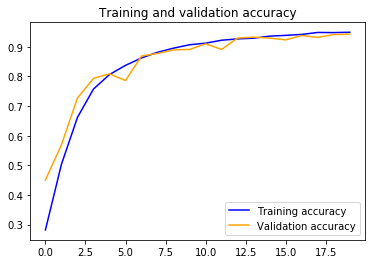

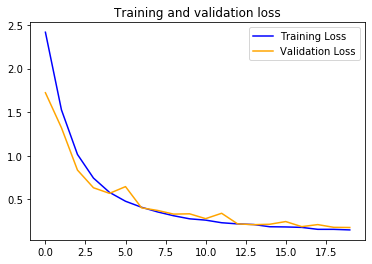

In [20]:

import matplotlib.pyplot as plt
acc = results.history['acc']
val_acc = results.history['val_acc']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

KeyError: 'acc'

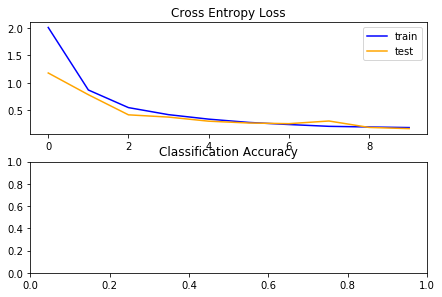

In [15]:
import matplotlib.pyplot as plt

def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title("Cross Entropy Loss")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history["val_loss"], color="orange", label="test")
    plt.legend()
    # plot accuracy
    plt.tight_layout()
    plt.subplot(212)
    plt.title("Classification Accuracy")
    plt.plot(history.history["acc"], color="blue", label="train")
    plt.plot(history.history["val_acc"], color="orange", label="test")
    plt.legend()
    # save plot to file
    plt.savefig("Model Performance.png")
    plt.close()
    
summarize_diagnostics(results)

In [20]:
#loaded_model = load_model('Plant_Classifier.h5')
#loaded_model.layers[0].input_shape #(None, 160, 160, 3)
#loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 270, 361, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 135, 180, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 133, 178, 16)      2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 66, 89, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 93984)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               24060160  
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
__________

In [16]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory('Dataset/val',
                                                        target_size=image_shape[:2],
                                                        batch_size=batch_size,
                                                        shuffle = False,
                                                        class_mode='categorical')

Found 6353 images belonging to 25 classes.


In [17]:
import numpy as np
test_generator.reset()
Y_pred = model.predict_generator(test_generator, 6353 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
#target_names = ['cup_cakes', 'french_fries', 'greek_salad' , 'hamburger' , 'pizza' , 'steak']
print(classification_report(test_generator.classes, y_pred))

Confusion Matrix
[[  91    4    2    5    0    0    0    0    8    0    1    5    1    0
     3    1    0    2    0    1    0    2    0    0    0]
 [   1  123    0    0    0    0    0    0    0    0    1    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0   48    0    0    0    2    0    0    0    3    1    0    0
     0    0    0    1    0    0    0    0    0    0    0]
 [   1    0    4  314    0    0    0    0    1    0    0    1    1    0
     0    0    0    0    0    0    5    2    0    0    0]
 [   0    0    0    0  227    6    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    1  275    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0  215    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0   84    0    0    0    0    0    0
 

In [18]:
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

data = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(test_generator.classes), index = np.unique(test_generator.classes))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

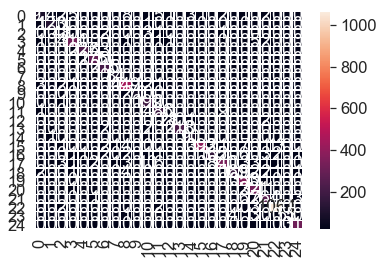

In [41]:
def Confusion_Matrix_Built_IN():

    CM = confusion_matrix(test_generator.classes, y_pred)
    #print(CM)
    df_cm = pd.DataFrame(CM, range(25), range(25))

    
    sn.heatmap(df_cm,vmin=20,vmax=max(CM.diagonal()),linewidth=.5 ,annot=True,fmt="d",xticklabels=True, yticklabels=True)# font size
    
    plt.show()

Confusion_Matrix_Built_IN()

In [71]:
test_score = model.evaluate_generator(test_generator , 1200 // batch_size)

In [72]:
test_score

[0.9690494214495023, 0.71]

In [73]:
validation_score = model.evaluate_generator(valid_image_gen , 600 // 16)
validation_score

[0.8750278802767192, 0.7191780821917808]

In [74]:
training_score = model.evaluate_generator(train_image_gen , 4200 // 16)
training_score

[0.5369298159791225, 0.8095124282982792]

In [22]:
loss_model = results.history["loss"]
acc_model = results.history["acc"]

In [23]:
loss_model

[2.417239946976755,
 1.5269251696395023,
 1.0150997633613665,
 0.7433301984477029,
 0.579484785562931,
 0.4774309474718722,
 0.4085401171237209,
 0.3550564682752984,
 0.311185090753374,
 0.27585088979464345,
 0.2608554669572495,
 0.2308845411580727,
 0.2174850416906071,
 0.21032773136481944,
 0.1849358021349856,
 0.1826268197575816,
 0.17740769040492968,
 0.15514986839901637,
 0.15500115847687598,
 0.148461742933717]

In [24]:
acc_model

[0.28199908,
 0.50344783,
 0.66185063,
 0.7574703,
 0.8064622,
 0.8374598,
 0.8624811,
 0.8815919,
 0.89558023,
 0.9070073,
 0.91239244,
 0.92230904,
 0.9267748,
 0.9292047,
 0.935969,
 0.93872726,
 0.9418796,
 0.9485125,
 0.9480528,
 0.9492349]